In [1]:
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/indian-buffet-process/data/new_annotations.h5ad")
adata = adata[adata.obs["cell_type"].eq("Macrophage")]

In [21]:
import torch
import numpy as np
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata, specimen_name: str = "folder"):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].X.todense())
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    folder = torch.tensor(pd.Categorical(adata.obs[specimen_name]).codes).float()
    return X, size_factor, folder

X, size_factor, folder = setup_torch_data(adata, specimen_name="orig.ident")

X = X.to(device)
size_factor = size_factor.to(device)
folder = folder.to(device)

In [27]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

def model(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape
    G = int(torch.max(group_assignments).item() + 1)

    # IBP stick-breaking beta parameters
    alpha_param = pyro.param(
        "alpha",
        dist.Gamma(torch.full((), alpha, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )
    beta_param = pyro.param(
        "beta",
        dist.Gamma(alpha_param,
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )

    with pyro.plate("ibp_features", K):
        v = pyro.sample("v", dist.Beta(alpha_param, beta_param))  # [K]

    pi = torch.cumprod(v, dim=0)

    W = pyro.sample(
        "W",
        dist.Normal(torch.full((), 0.0, device=device, dtype=dtype),
                    torch.full((), 1.0, device=device, dtype=dtype))
        .expand([K, D]).to_event(2)
    )

    # Shared dispersion across all groups
    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((D,), 2.0, device=device, dtype=dtype),
                   torch.full((D,), 1.0, device=device, dtype=dtype)).to_event(1)
    )

    # Per-group (folder) logits, shape [G, D]
    folder_logit = pyro.param(
        "folder_logit",
        torch.zeros(G, D, device=device, dtype=dtype),
    )

    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(pi).to_event(1))  # [N, K]
        logits = (z @ W) + size_factor.reshape(-1, 1)  # [N, D]

        # Add per-group logit shift
        group_logit_offset = folder_logit[group_assignments.int()]  # [N, D]
        logits = logits + group_logit_offset

        logits = torch.clamp(logits, -15, 15)
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)


def guide(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    with pyro.plate("ibp_features", K):
        qv_alpha = pyro.param("qv_alpha", torch.ones(K, device=device, dtype=dtype),
                              constraint=dist.constraints.greater_than(1e-2))
        qv_beta = pyro.param("qv_beta", torch.ones(K, device=device, dtype=dtype),
                             constraint=dist.constraints.greater_than(1e-2))
        pyro.sample("v", dist.Beta(qv_alpha, qv_beta))

    with pyro.plate("observations", N):
        qz_logits = pyro.param("qz_logits", (torch.randn(N, K, device=device, dtype=dtype) * 0.01 - 2.0))
        pyro.sample("Z", dist.RelaxedBernoulliStraightThrough(
            temperature=torch.full((), 0.5, device=device, dtype=dtype),
            logits=qz_logits
        ).to_event(1))

    qW_loc = pyro.param("qW_loc", torch.randn(K, D, device=device, dtype=dtype))
    qW_scale = pyro.param("qW_scale", torch.ones(K, D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    pyro.sample("W", dist.Normal(qW_loc, qW_scale).to_event(2))

    # Shared dispersion
    qr_alpha = pyro.param("qr_alpha", torch.ones(D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    qr_beta = pyro.param("qr_beta", torch.ones(D, device=device, dtype=dtype),
                         constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(qr_alpha, qr_beta).to_event(1))


In [28]:
# Example training loop
pyro.clear_param_store()

X = X.to(device=device, dtype=dtype)
size_factor = size_factor.to(device=device, dtype=dtype)
K = torch.tensor(40, device=device)  # or whatever value, as a tensor
folder = folder.to(device)

optimizer = ClippedAdam({"lr": 0.01})
elbo = JitTrace_ELBO() # Real Fn Fast
svi = SVI(model, guide, optimizer, loss=elbo)

import wandb
wandb.init(project="ibp-nb-model-choroid-plexus", name="macrophage-2-individual-dispersions", config={
    "latent_dim_K": K,
    "learning_rate": 1e-2,
    "elbo": "JitTrace_ELBO",
})

In [29]:
for step in range(100_000):
    loss = svi.step(X.float(), K.float(), size_factor.float(), group_assignments=folder.float())
    if step % 1 == 0:
        mean_logits = pyro.get_param_store()["qz_logits"].mean().item()
        percentage_logits_above_0 = (pyro.get_param_store()["qz_logits"] > 0).float().mean().item()
        
        wandb.log({
            "step": step,
            "loss": loss,
            "mean_logits": mean_logits,
            "percentage_logits_above_0": percentage_logits_above_0
        })
        
        print(f"[Step {step}] Loss: {loss:.2e}", mean_logits, percentage_logits_above_0)

/tmp/ipykernel_182257/2470522040.py:67: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())
/tmp/ipykernel_182257/2470522040.py:11: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())
/tmp/ipykernel_182257/2470522040.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  G = int(torch.max(group_assignme

[Step 0] Loss: 2.84e+08 -1.9961990118026733 0.0
[Step 1] Loss: 2.85e+08 -1.9938758611679077 0.0
[Step 2] Loss: 2.74e+08 -1.9922291040420532 0.0
[Step 3] Loss: 2.74e+08 -1.990607500076294 0.0
[Step 4] Loss: 2.72e+08 -1.9889328479766846 0.0
[Step 5] Loss: 2.60e+08 -1.9871249198913574 0.0
[Step 6] Loss: 2.58e+08 -1.985206127166748 0.0
[Step 7] Loss: 2.54e+08 -1.98308527469635 0.0
[Step 8] Loss: 2.50e+08 -1.9808106422424316 0.0
[Step 9] Loss: 2.47e+08 -1.978339672088623 0.0
[Step 10] Loss: 2.38e+08 -1.9755586385726929 0.0
[Step 11] Loss: 2.38e+08 -1.9725451469421387 0.0
[Step 12] Loss: 2.33e+08 -1.9692996740341187 0.0
[Step 13] Loss: 2.30e+08 -1.9658384323120117 0.0
[Step 14] Loss: 2.31e+08 -1.962188482284546 0.0
[Step 15] Loss: 2.26e+08 -1.9583611488342285 0.0
[Step 16] Loss: 2.26e+08 -1.9544074535369873 0.0
[Step 17] Loss: 2.21e+08 -1.9502997398376465 0.0
[Step 18] Loss: 2.18e+08 -1.9460418224334717 0.0
[Step 19] Loss: 2.18e+08 -1.9417006969451904 0.0
[Step 20] Loss: 2.16e+08 -1.93726646

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/torch/autograd/function.py(575): apply
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/distributions/relaxed_straight_through.py(86): rsample
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/torch/distributions/independent.py(108): rsample
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/distributions/torch_distribution.py(49): __call__
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/poutine/runtime.py(345): default_process_message
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/poutine/runtime.py(383): apply_stack
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/primitives.py(189): sample
/tmp/ipykernel_182257/2470522040.py(79): guide
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/poutine/trace_messenger.py(191): __call__
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/poutine/trace_messenger.py(216): get_trace
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/enum.py(60): get_importance_trace
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(57): _get_trace
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/elbo.py(237): _get_traces
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(193): loss_and_surrogate_loss
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/poutine/messenger.py(32): _context_wrap
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/ops/jit.py(98): compiled
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/torch/jit/_trace.py(764): _trace_impl
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/torch/jit/_trace.py(1002): trace
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/ops/jit.py(107): __call__
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(239): loss_and_surrogate_loss
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(250): loss_and_grads
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/svi.py(145): step
/tmp/ipykernel_182257/1639097067.py(2): <module>
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3670): run_code
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3610): run_ast_nodes
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3365): run_cell_async
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3153): _run_cell
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3098): run_cell
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py(549): run_cell
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py(449): do_execute
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(778): execute_request
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py(362): execute_request
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(534): process_one
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
/usr/lib/python3.13/asyncio/events.py(89): _run
/usr/lib/python3.13/asyncio/base_events.py(2034): _run_once
/usr/lib/python3.13/asyncio/base_events.py(677): run_forever
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py(205): start
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py(739): start
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/traitlets/config/application.py(1075): launch_instance
/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel_launcher.py(18): <module>
<frozen runpy>(88): _run_code
<frozen runpy>(198): _run_module_as_main
RuntimeError: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/torch/autograd/function.py(559): apply
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/ops/jit.py(120): __call__
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(239): loss_and_surrogate_loss
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/trace_elbo.py(250): loss_and_grads
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/infer/svi.py(145): step
  /tmp/ipykernel_182257/1639097067.py(2): <module>
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3670): run_code
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3610): run_ast_nodes
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3365): run_cell_async
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3153): _run_cell
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py(3098): run_cell
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /usr/lib/python3.13/asyncio/events.py(89): _run
  /usr/lib/python3.13/asyncio/base_events.py(2034): _run_once
  /usr/lib/python3.13/asyncio/base_events.py(677): run_forever
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py(205): start
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py(739): start
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main



In [30]:
pyro.get_param_store().save("/home/jhaberbe/Projects/indian-buffet-process/output/choroid-plexus/macrophage-latent-features-05-08-2025.pt")
output = pyro.get_param_store()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79ad83d83250>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79ace7129f60, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/sample-specific-changes.ipynb#X21sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79ad83d83250>> (for post_run_cell), with arguments args (<ExecutionResult object at 79ace7129fd0, execution_count=30 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79ace7129f60, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/sample-specific-changes.ipynb#X21sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

# Outcome

In [2]:
import torch
import numpy as np
output = torch.load(open("/home/jhaberbe/Projects/indian-buffet-process/output/choroid-plexus/macrophage-latent-features-05-08-2025.pt", "rb"), weights_only=False)["params"]

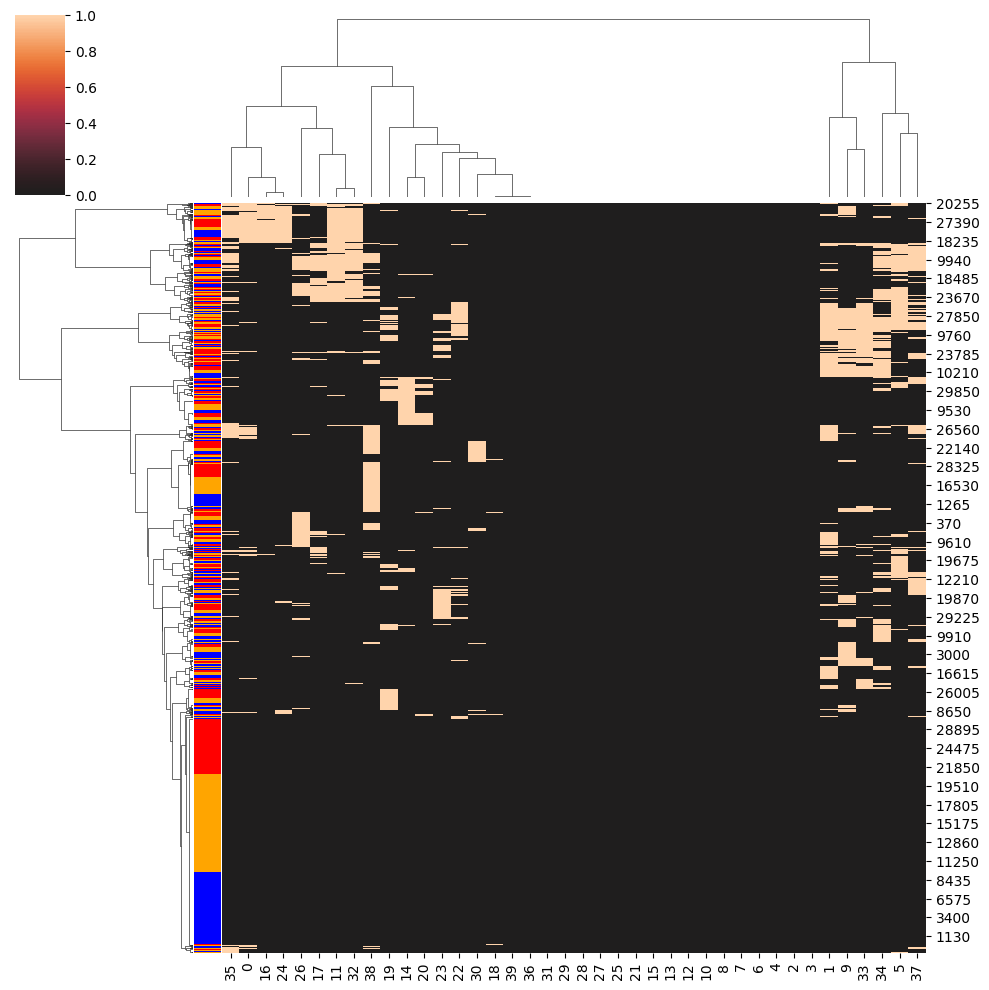

In [4]:
import pandas as pd
import seaborn as sns

sns.clustermap(
    pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0).iloc[::5],
    method="ward",
    metric="cityblock",
    center=0,
    row_colors=adata.obs["cogdx"].iloc[::5].replace({
    1: "blue",
    2: "orange",
    4: "red"
}).tolist(),
xticklabels=True
)

In [6]:
latent_features = pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0)
latent_features["specimen"] = adata.obs["orig.ident"].tolist()

latent_features = latent_features.groupby(["specimen"]).sum().div(adata.obs["orig.ident"].value_counts(), axis=0)
latent_features["group"] = adata.obs.drop_duplicates(subset="orig.ident").set_index("orig.ident")["cogdx"]

In [7]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from itertools import combinations

alpha = 0.1
groups = ["C", "M", "A"]
eps = 1e-3
n_samples = 1_000  # reduce if performance is an issue

def run_pymc_beta_model(feature_vals, group_labels):
    group_idx = pd.Categorical(group_labels, categories=groups).codes
    clipped_vals = np.clip(feature_vals, eps, 1 - eps)

    with pm.Model() as model:
        a = pm.Exponential('a', 1.0, shape=len(groups))
        b = pm.Exponential('b', 1.0, shape=len(groups))
        
        obs = pm.Beta('obs', alpha=a[group_idx], beta=b[group_idx],
                      observed=clipped_vals)
        
        trace = pm.sample(n_samples, tune=1000, chains=4, progressbar=True, target_accept=0.9)
        
    return trace

def credible_difference(trace, param, group1, group2, threshold=0.95):
    # Extract posterior samples for group-specific parameter (e.g. alpha[0], alpha[1])
    samples1 = trace.posterior[param].sel(a_dim_0=groups.index(group1)).values.flatten()
    samples2 = trace.posterior[param].sel(a_dim_0=groups.index(group2)).values.flatten()
    
    diff = samples1 - samples2
    prob_diff = np.mean(diff > 0)  # P(group1 > group2)

    # Two-sided
    prob = max(prob_diff, 1 - prob_diff)
    return prob > threshold, prob

# ---- Main Loop ----
for feature in latent_features.columns:
    if feature == "group":
        continue
    if latent_features[feature].mean() == 1 or latent_features[feature].mean() == 0:
        continue

    df = latent_features[[feature, "group"]].dropna()
    if df["group"].nunique() < 2:
        continue

    print(f"\n🔎 Running Bayesian beta model for '{feature}'")
    trace = run_pymc_beta_model(df[feature].values, df["group"])

    # Pairwise group comparisons based on posterior of means
    for g1, g2 in combinations(groups, 2):
        # Compute posterior means from alpha and beta
        a1 = trace.posterior['a'].sel(a_dim_0=groups.index(g1)).values.flatten()
        b1 = trace.posterior['b'].sel(b_dim_0=groups.index(g1)).values.flatten()
        a2 = trace.posterior['a'].sel(a_dim_0=groups.index(g2)).values.flatten()
        b2 = trace.posterior['b'].sel(b_dim_0=groups.index(g2)).values.flatten()

        mean1 = a1 / (a1 + b1)
        mean2 = a2 / (a2 + b2)

        prob_diff = np.mean(mean1 > mean2)
        prob = max(prob_diff, 1 - prob_diff)

        direction = ">" if prob_diff > 0.5 else "<"
        print(f"  ➤ {g1} {direction} {g2} with {prob:.2%} certainty based on mean")




🔎 Running Bayesian beta model for '0'


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.68% certainty based on mean
  ➤ C > A with 88.78% certainty based on mean
  ➤ M > A with 87.33% certainty based on mean

🔎 Running Bayesian beta model for '1'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.18% certainty based on mean
  ➤ C > A with 79.88% certainty based on mean
  ➤ M > A with 79.92% certainty based on mean

🔎 Running Bayesian beta model for '5'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.05% certainty based on mean
  ➤ C > A with 83.30% certainty based on mean
  ➤ M > A with 81.80% certainty based on mean

🔎 Running Bayesian beta model for '9'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.10% certainty based on mean
  ➤ C > A with 82.80% certainty based on mean
  ➤ M > A with 81.90% certainty based on mean

🔎 Running Bayesian beta model for '11'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.60% certainty based on mean
  ➤ C > A with 84.45% certainty based on mean
  ➤ M > A with 84.47% certainty based on mean

🔎 Running Bayesian beta model for '14'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.20% certainty based on mean
  ➤ C > A with 90.42% certainty based on mean
  ➤ M > A with 90.25% certainty based on mean

🔎 Running Bayesian beta model for '16'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.90% certainty based on mean
  ➤ C > A with 93.17% certainty based on mean
  ➤ M > A with 92.50% certainty based on mean

🔎 Running Bayesian beta model for '17'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.02% certainty based on mean
  ➤ C > A with 87.38% certainty based on mean
  ➤ M > A with 89.12% certainty based on mean

🔎 Running Bayesian beta model for '18'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.50% certainty based on mean
  ➤ C > A with 96.85% certainty based on mean
  ➤ M > A with 96.67% certainty based on mean

🔎 Running Bayesian beta model for '19'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.12% certainty based on mean
  ➤ C > A with 86.20% certainty based on mean
  ➤ M > A with 86.10% certainty based on mean

🔎 Running Bayesian beta model for '20'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.28% certainty based on mean
  ➤ C > A with 93.08% certainty based on mean
  ➤ M > A with 92.53% certainty based on mean

🔎 Running Bayesian beta model for '22'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.18% certainty based on mean
  ➤ C > A with 91.17% certainty based on mean
  ➤ M > A with 91.88% certainty based on mean

🔎 Running Bayesian beta model for '23'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.50% certainty based on mean
  ➤ C > A with 90.85% certainty based on mean
  ➤ M > A with 90.38% certainty based on mean

🔎 Running Bayesian beta model for '24'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.75% certainty based on mean
  ➤ C > A with 93.15% certainty based on mean
  ➤ M > A with 92.55% certainty based on mean

🔎 Running Bayesian beta model for '26'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.98% certainty based on mean
  ➤ C > A with 87.58% certainty based on mean
  ➤ M > A with 86.88% certainty based on mean

🔎 Running Bayesian beta model for '30'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.10% certainty based on mean
  ➤ C > A with 93.08% certainty based on mean
  ➤ M > A with 93.73% certainty based on mean

🔎 Running Bayesian beta model for '32'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.08% certainty based on mean
  ➤ C > A with 85.42% certainty based on mean
  ➤ M > A with 85.17% certainty based on mean

🔎 Running Bayesian beta model for '33'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.42% certainty based on mean
  ➤ C > A with 85.97% certainty based on mean
  ➤ M > A with 87.17% certainty based on mean

🔎 Running Bayesian beta model for '34'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.28% certainty based on mean
  ➤ C > A with 78.88% certainty based on mean
  ➤ M > A with 79.53% certainty based on mean

🔎 Running Bayesian beta model for '35'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.75% certainty based on mean
  ➤ C > A with 84.60% certainty based on mean
  ➤ M > A with 84.03% certainty based on mean

🔎 Running Bayesian beta model for '37'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 50.52% certainty based on mean
  ➤ C > A with 83.10% certainty based on mean
  ➤ M > A with 83.35% certainty based on mean

🔎 Running Bayesian beta model for '38'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


  ➤ C > M with 51.52% certainty based on mean
  ➤ C > A with 81.55% certainty based on mean
  ➤ M > A with 80.17% certainty based on mean


<Axes: xlabel='variable', ylabel='value'>

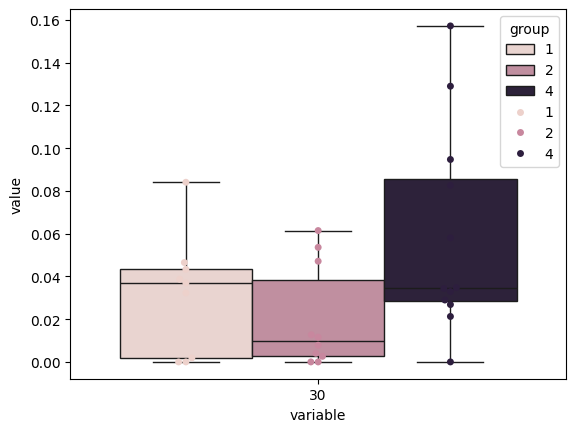

In [18]:
import seaborn as sns

module = 30
sns.boxplot(
    latent_features.reset_index().melt(id_vars=["index", "group"]).query("variable == @module"),
    x="variable",
    y="value",
    hue="group",
)
sns.swarmplot(
    latent_features.reset_index().melt(id_vars=["index", "group"]).query("variable == @module"),
    x="variable",
    y="value",
    hue="group",
    dodge=True,
    edgecolor="k"
)

In [15]:
import pandas as pd
table = pd.DataFrame(
    output["qW_loc"].cpu().detach().numpy(),
    columns=adata[:, (adata.X > 0).mean(axis=0) > 0.05].var_names
)

module = 20
table.T.sort_values(by=module, ascending=False)[module].iloc[3:]

LYVE1         0.793833
FGF13         0.769718
MRC1          0.757403
THBS1         0.697261
RBPJ          0.674024
                ...   
CACNA1D      -0.339605
IFNLR1       -0.344400
SLC7A5       -0.357060
AC093895.1   -0.381418
SYNDIG1      -0.414010
Name: 20, Length: 5336, dtype: float32

In [16]:
module = 23
table.T.sort_values(by=module, ascending=False)[module].iloc[3:]

SH3BP4        0.495088
CADM1         0.491092
SULF2         0.474518
PADI2         0.464853
CXCR4         0.463738
                ...   
SLC39A14     -0.315872
LYVE1        -0.320042
AL357522.1   -0.324311
PDIA4        -0.335150
MIPOL1       -0.354294
Name: 23, Length: 5336, dtype: float32

In [19]:
module = 30
table.T.sort_values(by=module, ascending=False)[module].iloc[3:]

RASGEF1C     0.655784
LINC01141    0.652819
DSCAM        0.617452
FOXP2        0.591161
HS3ST4       0.576612
               ...   
F13A1       -0.322607
MYRIP       -0.338108
TTN         -0.342168
SIGLEC1     -0.345072
THBS1       -0.442212
Name: 30, Length: 5336, dtype: float32